# Supervised Experiment

In [1]:
import torch
from torch import nn

from src.aae_supervised import SupervisedAdversarialAutoencoder
from src.dataloader import load_mnist_data
from matplotlib import pyplot as plt

### Paper Config

In [2]:
NUM_EPOCHS = 5000

INPUT_DIM = 784
BATCH_SIZE = 100
AE_HIDDEN = 1000
DC_HIDDEN = 1000
LATENT_DIM = 15
NUM_CLASSES = 10
PRIOR_STD = 5.0
recon_loss = nn.MSELoss()
init_recon_lr = 0.001#0.0001#0.001#0.01
init_gen_lr = init_disc_lr = 0.001#0.00004#0.001#0.0005#0.1
# init_recon_lr = 0.01
# init_gen_lr = init_disc_lr = 0.1
use_decoder_sigmoid = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Load Training Data

In [3]:
train_loader, test_loader = load_mnist_data(BATCH_SIZE, -1)

### Model setup

In [4]:
aae = SupervisedAdversarialAutoencoder(
    input_dim=INPUT_DIM,
    ae_hidden=AE_HIDDEN,
    dc_hidden=DC_HIDDEN,
    latent_dim=LATENT_DIM,
    recon_loss_fn=recon_loss,
    num_classes=NUM_CLASSES,
    init_recon_lr=init_recon_lr,
    init_gen_lr=init_gen_lr,
    init_disc_lr=init_disc_lr,
    use_decoder_sigmoid=use_decoder_sigmoid,
    device = "cuda" if torch.cuda.is_available() else "cpu"
)

### Train Model

In [5]:
# aae.load_weights("weights/supervised_2_2000")
aae.train_mbgd(
    data_loader=train_loader,
    epochs=NUM_EPOCHS,
    csv_log_path="logs/supervised/supervised_no_noise.csv",
    model = "no noise",
    prior_std=PRIOR_STD,
)
aae.save_weights("weights/supervised_" + str(LATENT_DIM) + "_" + str(NUM_EPOCHS)+ "_" + str(PRIOR_STD))

wandb: Currently logged in as: savvididanae (traffic-forecasting-gnns-rp) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Training Epochs: 100%|██████████| 5000/5000 [6:13:47<00:00,  4.49s/epoch]  


Weights saved to weights/supervised_15_5000_5.0_*.pth


### Visualize

In [6]:
# aae.load_weights("weights/supervised_15_20_5.0")

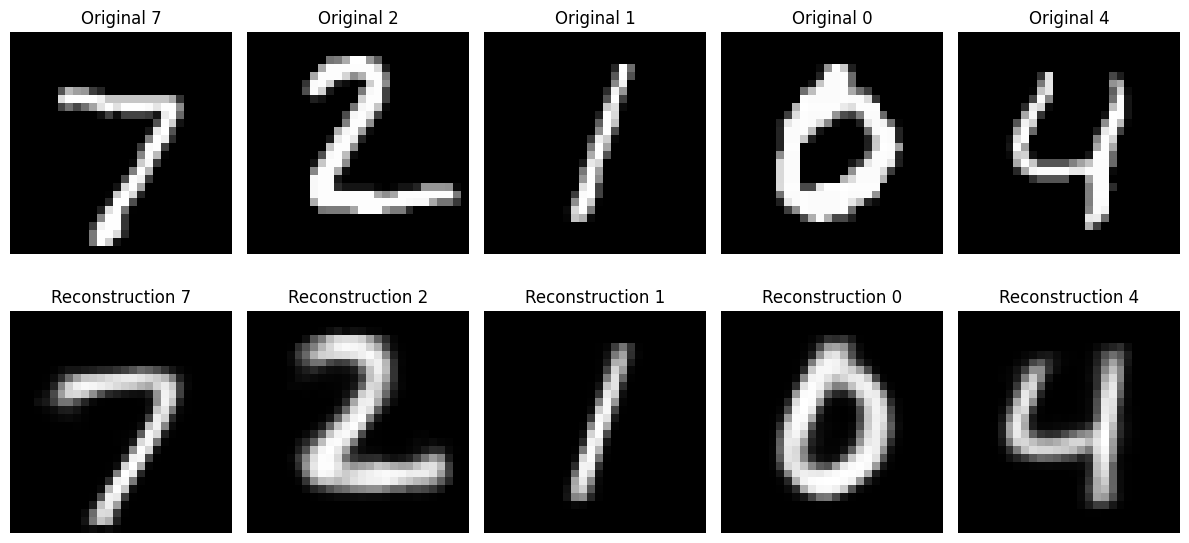

In [7]:
def display_reconstructions(model, test_loader, num_images=5):
    model.eval()
    data_iter = iter(test_loader)
    images, labels = next(data_iter)
    images = images.to(model.device)
    labels_one_hot = torch.nn.functional.one_hot(labels, num_classes=model.num_classes).float().to(model.device)


    fig, axes = plt.subplots(2, num_images, figsize=(12, 6))

    with torch.no_grad():
        for i in range(num_images):
            img = images[i].view(1, -1)
            label_onehot = labels_one_hot[i].view(1, -1)

            # Encode and decode per image
            z = model.encoder(img)
            z_cat = torch.cat([z, label_onehot], dim=1)
            recon = model.decoder(z_cat)

            ax_orig = axes[0, i]
            ax_orig.imshow(images[i].cpu().squeeze().numpy().reshape(28, 28), cmap='gray')
            ax_orig.axis('off')
            ax_orig.set_title(f"Original {labels[i].item()}")

            ax_recon = axes[1, i]
            ax_recon.imshow(recon.cpu().squeeze().numpy().reshape(28, 28), cmap='gray')
            ax_recon.axis('off')
            ax_recon.set_title(f"Reconstruction {labels[i].item()}")

    plt.tight_layout()
    plt.show()

display_reconstructions(aae, test_loader)

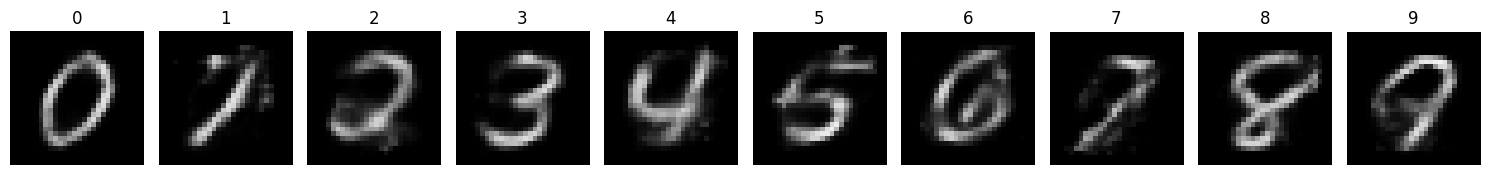

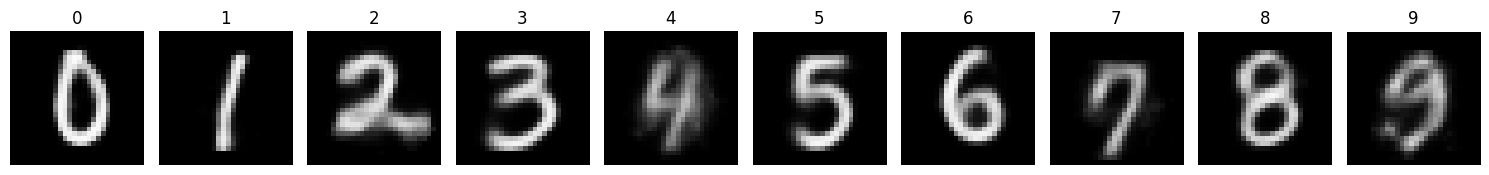

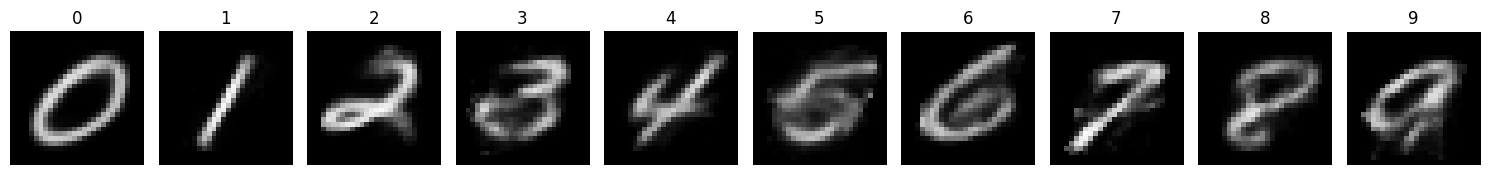

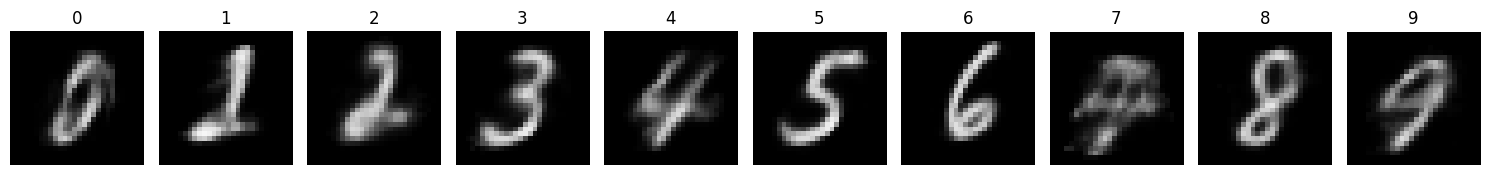

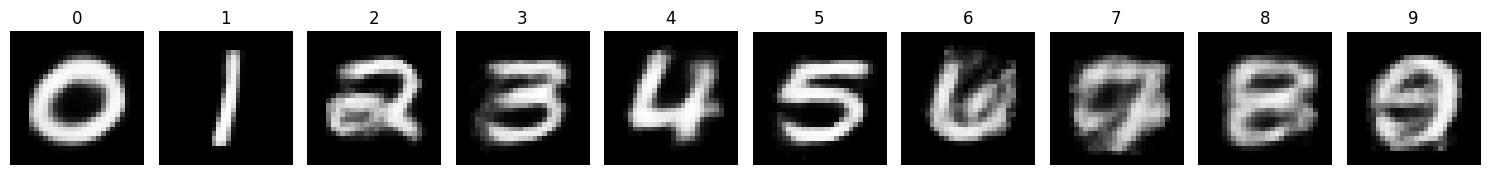

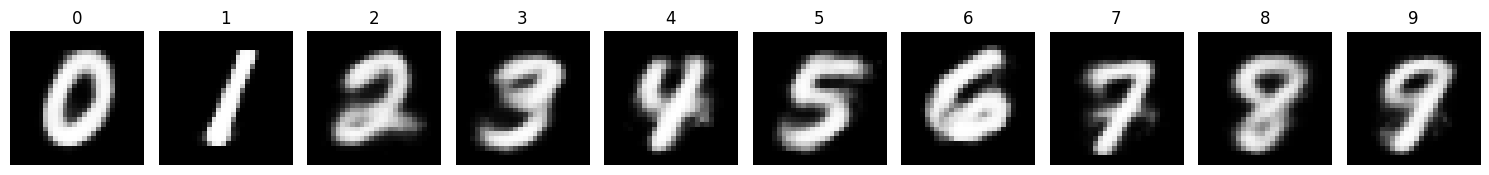

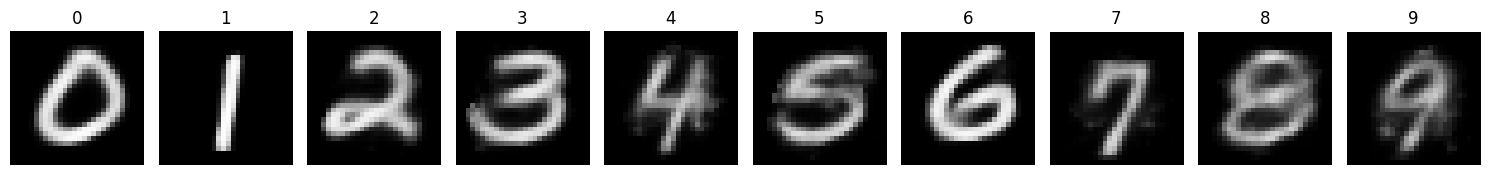

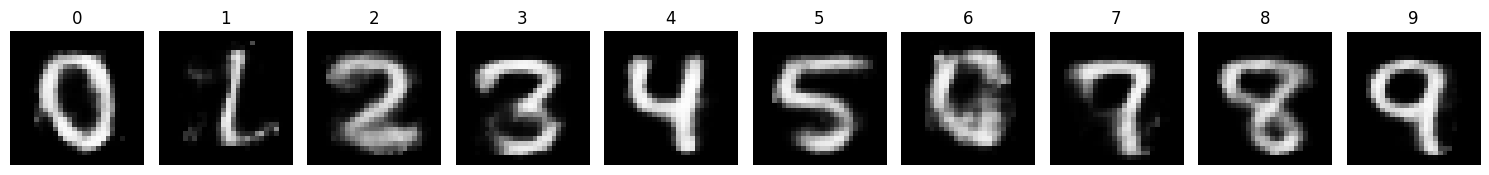

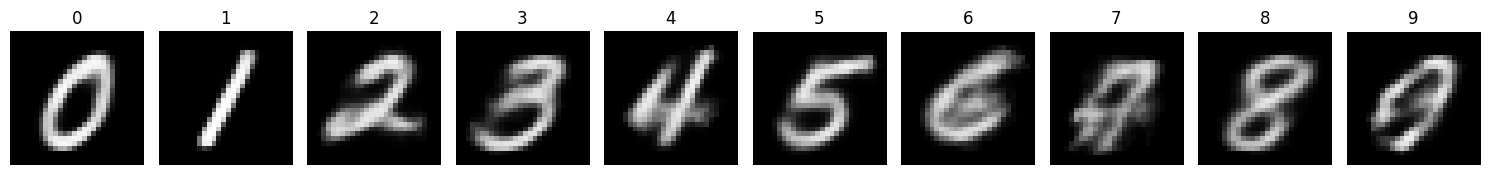

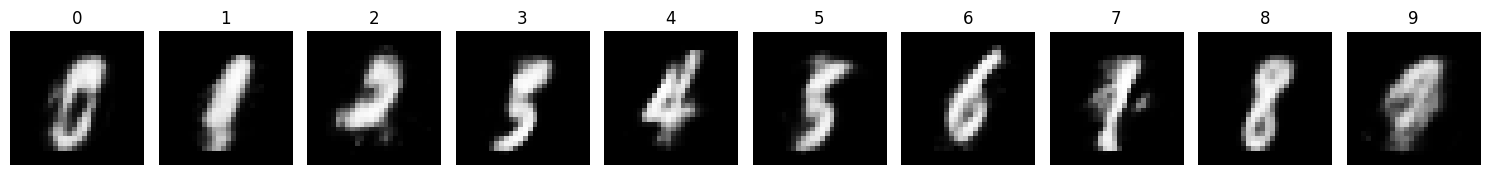

In [8]:
from matplotlib import pyplot as plt


def generate_image_grid(aae, latent_dim, prior_std, n_classes=10):
    aae.eval()
    fig, axes = plt.subplots(1, n_classes, figsize=(15, 2))

    z = torch.randn(1, latent_dim).to(device) * prior_std
    for i in range(n_classes):
        y = torch.zeros(1, n_classes).to(device)
        y[0, i] = 1

        with torch.no_grad():
            x_hat = aae.decoder(torch.cat([z, y], dim=1))
            x_hat = x_hat.view(28, 28).cpu()

        axes[i].imshow(x_hat, cmap='gray', vmin=0, vmax=1)
        axes[i].axis('off')
        axes[i].set_title(f'{i}')

    plt.tight_layout()
    plt.show()

# Usage
for i in range(0, 10):
    generate_image_grid(aae, latent_dim=LATENT_DIM, prior_std=PRIOR_STD)

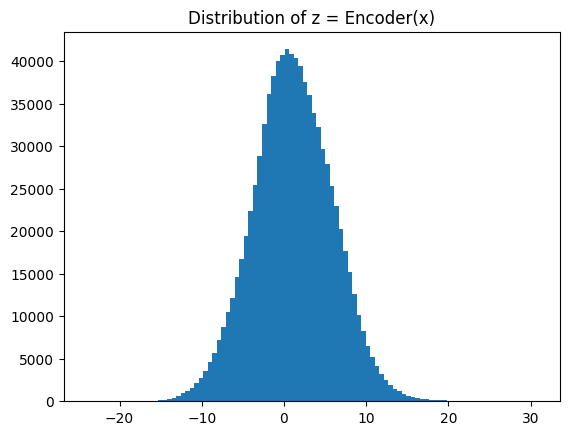

In [9]:
z_all = []
aae.eval()
for x, y in train_loader:
    x = x.view(x.size(0), -1).to(device)
    z = aae.encoder(x)
    z_all.append(z.cpu())

z_all = torch.cat(z_all, dim=0).detach().cpu().numpy()
plt.hist(z_all.flatten(), bins=100)
plt.title("Distribution of z = Encoder(x)")
plt.show()
